In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import pandas as pd

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut
import matplotlib.ticker as tkr

import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [2]:
mooring=1
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/Figures_poster/'

In [3]:
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)

In [4]:
# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')

#Velocity time series
ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

ds['uz'] = wkb*ds['u'].differentiate('z')
ds['vz'] = wkb*ds['v'].differentiate('z')

#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#N
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

#Low frequency motion
ds_low = xr.open_dataset(root_dir+'data/M%s_lpfiltered.nc'%mooring).interpolate_na(dim='time',method='cubic',max_gap=pd.Timedelta(3, "d"))

alt = niskine.io.load_ssh()
alt['eke'] = 1/2 * (alt.ugosa**2 + alt.vgosa**2)
from datetime import datetime
eke = alt.eke.sel(time=slice('2019-06-01','2020-10-01'))#.plot()
_time = eke.time

In [5]:
alt['ugos_mean'] = alt.ugos.mean('time')
alt['vgos_mean'] = alt.vgos.mean('time')

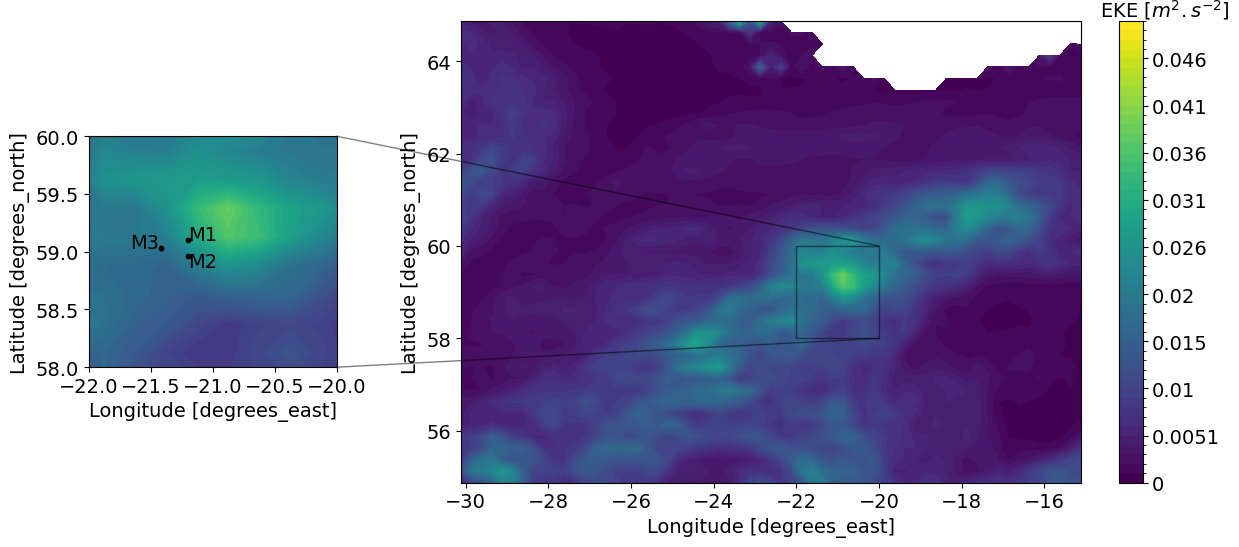

In [27]:

fig,ax = plt.subplots(figsize=(10,6))
c1 = eke.mean('time').plot.contourf(ax=ax,vmax=0.05,vmin=0,levels=50,cmap='viridis',add_colorbar=False)
#alt.plot.quiver(ax=ax,x='lon',y='lat',u='ugos_mean',v='vgos_mean')
#ax.scatter(m1lon,m1lat,s=2);ax.scatter(m2lon,m2lat,s=2);ax.scatter(m3lon,m3lat,s=2)
axins = ax.inset_axes([-0.6, 0.25, 0.4, 0.5])
eke.mean('time').plot.contourf(ax=axins,vmax=0.05,vmin=0,levels=50,cmap='viridis',add_colorbar=False)
#alt.plot.quiver(ax=axins,x='lon',y='lat',u='ugos_mean',v='vgos_mean')
ax.set_title('')
    #fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
axins.set_xlim((-22),(-20))
axins.set_ylim((58),(60))
axins.scatter(m1lon,m1lat,s=10,c='k');axins.scatter(m2lon,m2lat,s=10,c='k');axins.scatter(m3lon,m3lat,s=10,c='k')
    #axins.set_ylabel('');axins.set_xlabel('')
axins.text(m1lon,m1lat,'M1',fontsize=14);axins.text(m2lon,m2lat-0.1,'M2',fontsize=14);axins.text(m3lon-0.25,m3lat,'M3',fontsize=14)
axins.set_title('')
ax.indicate_inset_zoom(axins,edgecolor='black')
cb1 = fig.colorbar(c1, format=tkr.FormatStrFormatter('%.2g'))
cb1.set_label(r'EKE [$m^2.s^{-2}$]', labelpad=-40, y=1.05, rotation=0)
plt.show();
fig.tight_layout()
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/Map.png')

In [6]:
d = 2 * (m1lon * (m2lat - m3lat) + m2lon * (m3lat - m1lat) + m3lon * (m1lat - m2lat))
midlon = ((m1lon * m1lon + m1lat * m1lat) * (m2lat - m3lat) + (m2lon * m2lon + m2lat * m2lat) * (m3lat - m1lat) + (m3lon * m3lon + m3lat * m3lat) * (m1lat - m2lat)) / d
midlat = ((m1lon * m1lon + m1lat * m1lat) * (m3lon - m2lon) + (m2lon * m2lon + m2lat * m2lat) * (m1lon - m3lon) + (m3lon * m3lon + m3lat * m3lat) * (m2lon - m1lon)) / d


In [165]:
ut.coriolis(midlat)*3600*24/2/np.pi

1.719607059176531

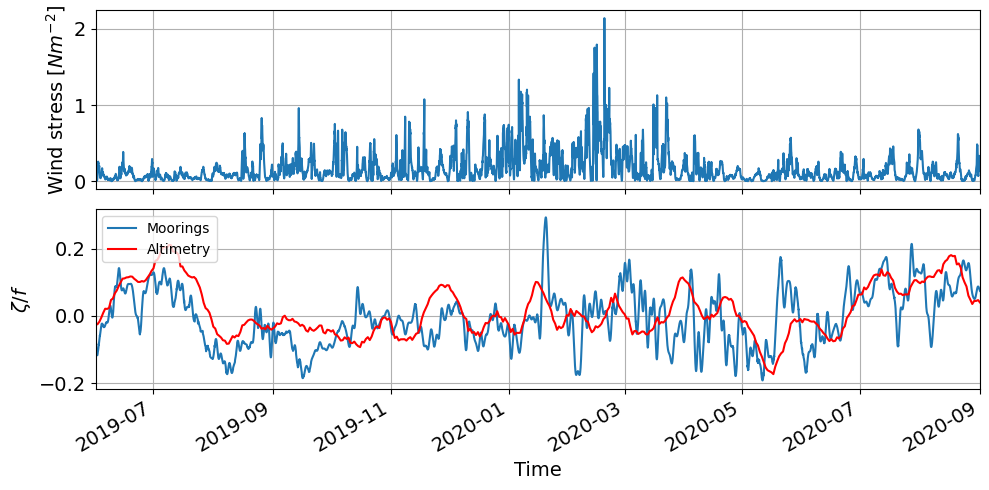

In [167]:
fig,axs = plt.subplots(2,1,figsize=(10,5),sharex=True)
ax = axs[0]
wind_stress['__xarray_dataarray_variable__'].plot(ax=ax)
ax.grid();ax.set_title('');ax.set_ylabel(r'Wind stress [$N m^{-2}$]')
ax = axs[1]
vort.vorticity_norm.mean('z').sel(time=slice('2019-06-01','2020-09-01')).plot(ax=ax,label='Moorings')
vort_alt.__xarray_dataarray_variable__.sel(lon=midlon,lat=midlat,method='nearest').sel(time=slice('2019-06-01','2020-09-01')).plot(ax=ax,c='r',label='Altimetry')
ax.grid();ax.set_title('');ax.legend()
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-09-01'))
fig.tight_layout()
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/wind_vort.jpg')

In [67]:
moorings={}
for mooring in [1,2,3]:
    #gridded=xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
    ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
    mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds.time[0],ds.time[-1]))
    ds['mld'] = mld_m1
    gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
    wkb = niskine.clim.get_wkb_factors(gridded)
    ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
    ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')
    moorings[str(mooring)] = ds

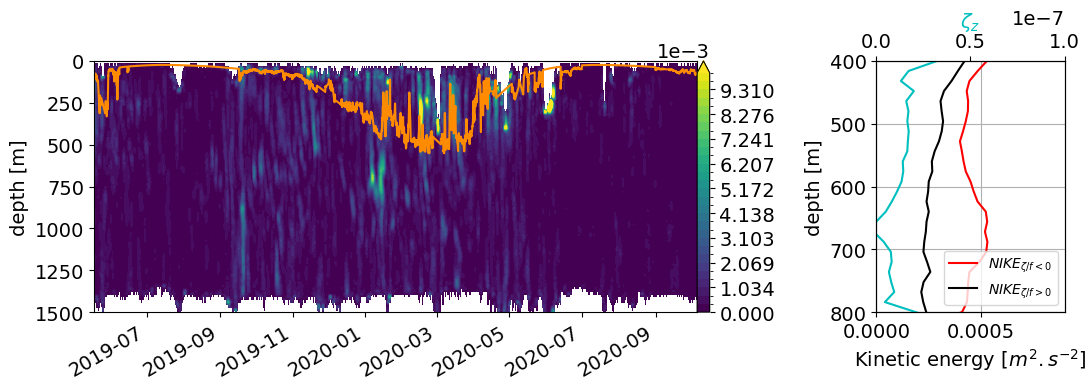

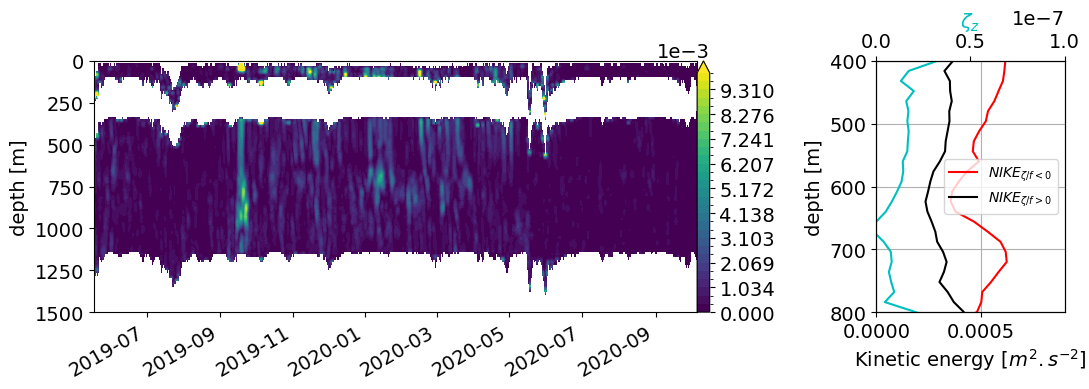

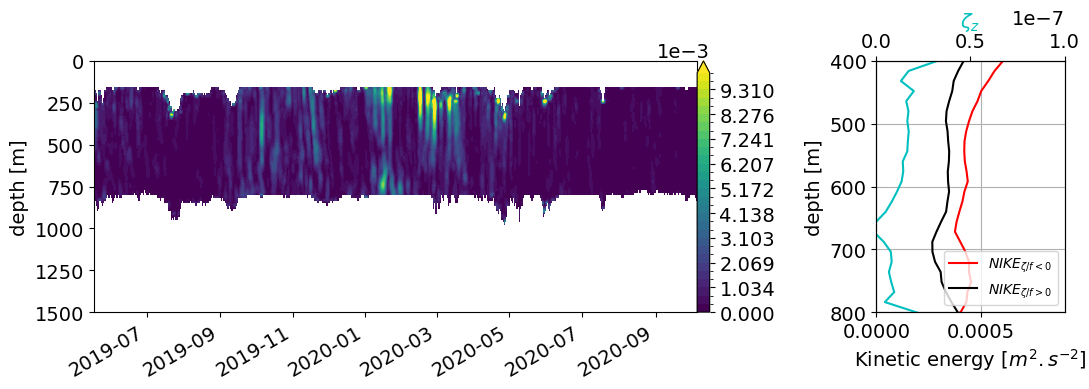

In [161]:
from matplotlib.gridspec import GridSpec
for m in moorings:
    fig = plt.figure(figsize=(11,4))
    gs = GridSpec(1, 4, figure=fig)
    ax = fig.add_subplot(gs[:,:3])
    c1 = moorings[m].ni_ke_wkb.plot.contourf(ax=ax,yincrease=False,levels=30,ylim=(1500,0),vmax=0.01,vmin=0,add_colorbar=False)
    if m=='1':
        moorings['1'].mld.plot(ax=ax,c='darkorange')
        ax.set_ylabel('depth [m]')
    ax.set_xlabel('');ax.set_title('')
    #cb1 = fig.colorbar(c1, format=tkr.FormatStrFormatter('%.2g'))
    #cb1.set_label(r'EKE [$m^2.s^{-2}$]', labelpad=-40, y=1.05, rotation=0)
    #fmt = FormatScalarFormatter("%.2f")
    cbar = fig.colorbar(c1,pad=0.)
    cbar.formatter.set_powerlimits((0, 0))
    ax = fig.add_subplot(gs[:,3:])
    (moorings[m].ni_ke_wkb.where(vort.vorticity_norm<0)).mean('time').plot(ax=ax,y='z',yincrease=False,c='r',label=r'$NI KE_{\zeta/f <0}$')
    (moorings[m].ni_ke_wkb.where(vort.vorticity_norm>0)).mean('time').plot(ax=ax,y='z',yincrease=False,c='k',label=r'$NI KE_{\zeta/f >0}$')
    ax.grid();ax.legend();ax.set_xlim(0,9e-4)
    ax.set_xlabel('Kinetic energy [$m^2.s^{-2}$]');
    ax1 = ax.twiny()
    vort.where(vort.vorticity_norm<0).vorticity_z.mean('time').plot(ax=ax1,y='z',yincrease=False,c='c')
    ax1.set_xlabel(r'$\zeta_z$',c='c');ax1.set_xlim(0,1e-7)  #1e-7
    fig.tight_layout()
    ax.set_ylim(800,400)
    fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/KE_M%s.jpg'%m)


In [20]:
class FormatScalarFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, fformat="%1.1f", offset=True, mathText=True):
        self.fformat = fformat
        mpl.ticker.ScalarFormatter.__init__(self,useOffset=offset,
                                                        useMathText=mathText)
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

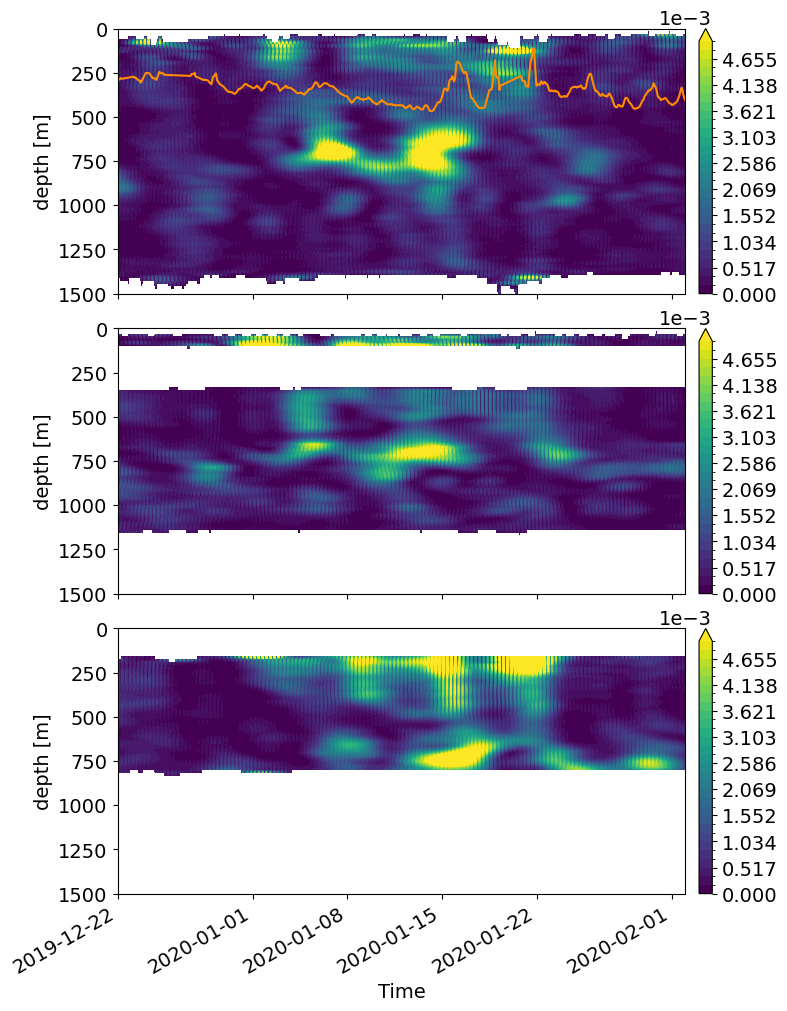

In [138]:
fig,axs = plt.subplots(3,1,figsize=(8,10),sharex=True)
for ax,m in zip(axs,['1','2','3']):
    c1 = moorings[m].ni_ke_wkb.sel(time=slice('2019-12-22','2020-02-01')).plot.contourf(ax=ax,yincrease=False,levels=30,ylim=(1500,0),vmax=0.005,vmin=0,add_colorbar=False)
    cbar = fig.colorbar(c1,pad=0.02)
    cbar.formatter.set_powerlimits((0, 0))
    ax.set_xlabel('');ax.set_title('')
moorings['1'].mld.sel(time=slice('2019-12-22','2020-02-01')).plot(ax=axs[0],c='darkorange')
axs[0].set_xlabel('');axs[0].set_title('')
axs[0].set_ylabel('depth [m]');
ax.set_xlabel('Time')
fig.tight_layout(pad=0.3)
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/KE_event01.jpg')

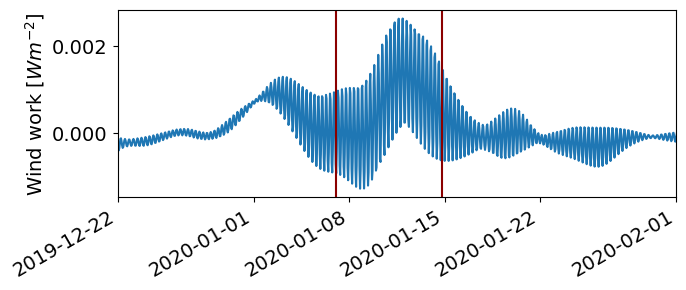

In [146]:
fig,ax = plt.subplots(figsize=(7,3))
wind_work.wind_work.sel(time=slice('2019-12-22','2020-02-01')).plot(ax=ax)
ax.set_xlim(np.datetime64('2019-12-22'),np.datetime64('2020-02-01'));
ax.set_title('');ax.set_ylabel(r'Wind work [$W m^{-2}$]')
ax.axvline(np.datetime64('2020-01-07T00'),c='darkred')
ax.axvline(np.datetime64('2020-01-14T20'),c='darkred')
fig.tight_layout() 
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/wind_event01.jpg')

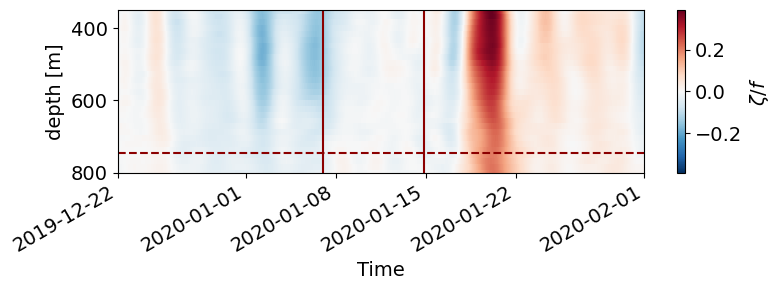

In [149]:
fig,ax = plt.subplots(figsize=(8,3))
vort.vorticity_norm.sel(time=slice('2019-12-22','2020-02-01')).plot(ax=ax,yincrease=False,ylim=(800,350))
ax.set_xlim(np.datetime64('2019-12-22'),np.datetime64('2020-02-01'));
ax.set_title('')
ax.axvline(np.datetime64('2020-01-07T00'),c='darkred')
ax.axvline(np.datetime64('2020-01-14T20'),c='darkred')
ax.axhline(745, c='darkred',ls='--');
ax.set_xlabel('Time')
fig.tight_layout() 
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/vort_event01.jpg')

In [78]:
ds = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

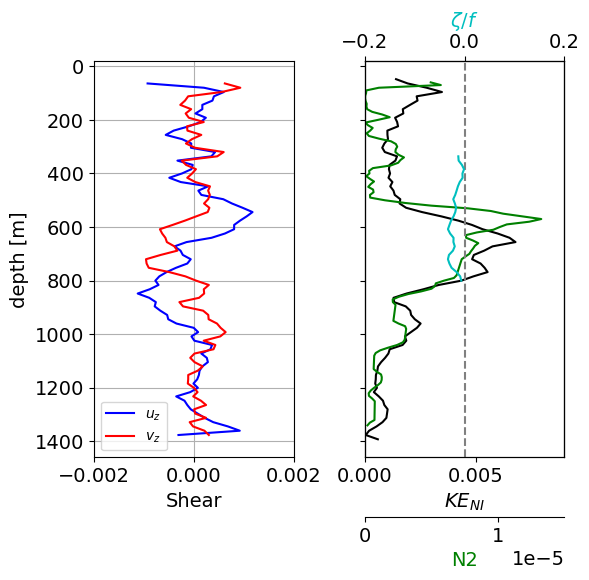

In [155]:
t = '2020-01-14T20'
fig,axs = plt.subplots(1,2,figsize=(6,6),sharey=True)
moorings['1'].bpuz.sel(time=t,method='nearest').plot(ax=axs[0],y='z',yincrease=False,c='b',label=r'$u_z$')
moorings['1'].bpvz.sel(time=t,method='nearest').plot(ax=axs[0],y='z',yincrease=False,c='r',label=r'$v_z$')
axs[0].set_xlabel('Shear');axs[0].legend();
axs[0].set_xlim(-0.002,0.002)
axs[0].grid();axs[0].set_title('')


moorings['1'].ni_ke_wkb.sel(time=t,method='nearest').plot(ax=axs[1],y='z',yincrease=False,xlim=(0,0.009),c='k')
axs[1].set_xlabel(r'$KE_{NI}$')
ax1 = axs[1].twiny()
N2.N2.sel(time=t,method='nearest').plot(ax=ax1,y='depth',yincrease=False,xlim=(0,1.5e-5),c='g')
ax1.set_xlabel('N2',c='g')
ax1.xaxis.set_label_position('bottom')
ax1.set_title('');
axs[1].set_title('')#;ax.grid()
ax2 = ax1.twiny()
vort.vorticity_norm.sel(time=t,method='nearest').plot(ax=ax2,y='z',yincrease=False,xlim=(-0.2,0.2),c='c')
ax2.set_xlabel(r'$\zeta / f$',c='c')
ax1.spines.bottom.set_position(("axes", -0.15))
ax2.axvline(0,ls='--',zorder=-1,c='grey')
ax2.set_title('')
axs[1].set_ylabel('')
fig.tight_layout()
fig.savefig('/Users/zcasparcohen/Documents/Figures_poster/bpuz_etc_event01_t1.jpg')

#### Supp

In [12]:
alt#.ugos.sel(time='2020-01-14T20',method='nearest').plot()

<xarray.Dataset>
Dimensions:    (time: 5725, lat: 41, lon: 61)
Coordinates:
  * lat        (lat) float32 54.88 55.12 55.38 55.62 ... 64.12 64.38 64.62 64.88
  * time       (time) datetime64[ns] 2005-05-01 2005-05-02 ... 2021-01-01
  * lon        (lon) float32 -30.12 -29.88 -29.62 ... -15.62 -15.38 -15.12
Data variables:
    ugos       (time, lat, lon) float64 -0.0539 -0.0555 -0.0481 ... nan nan nan
    vgos       (time, lat, lon) float64 -0.0412 -0.0124 0.0319 ... nan nan nan
    vgosa      (time, lat, lon) float64 -0.0746 -0.0497 -0.0027 ... nan nan nan
    crs        int32 ...
    err_vgosa  (time, lat, lon) float64 ...
    err_ugosa  (time, lat, lon) float64 ...
    sla        (time, lat, lon) float64 ...
    ugosa      (time, lat, lon) float64 -0.0299 -0.0146 0.0039 ... nan nan nan
    eke        (time, lat, lon) float64 0.00323 0.001342 1.125e-05 ... nan nan
    ugos_mean  (lat, lon) float64 -0.01207 -0.03155 -0.04603 ... nan nan nan
    vgos_mean  (lat, lon) float64 0.03635 0.04518 0.03907 ... nan nan nan
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

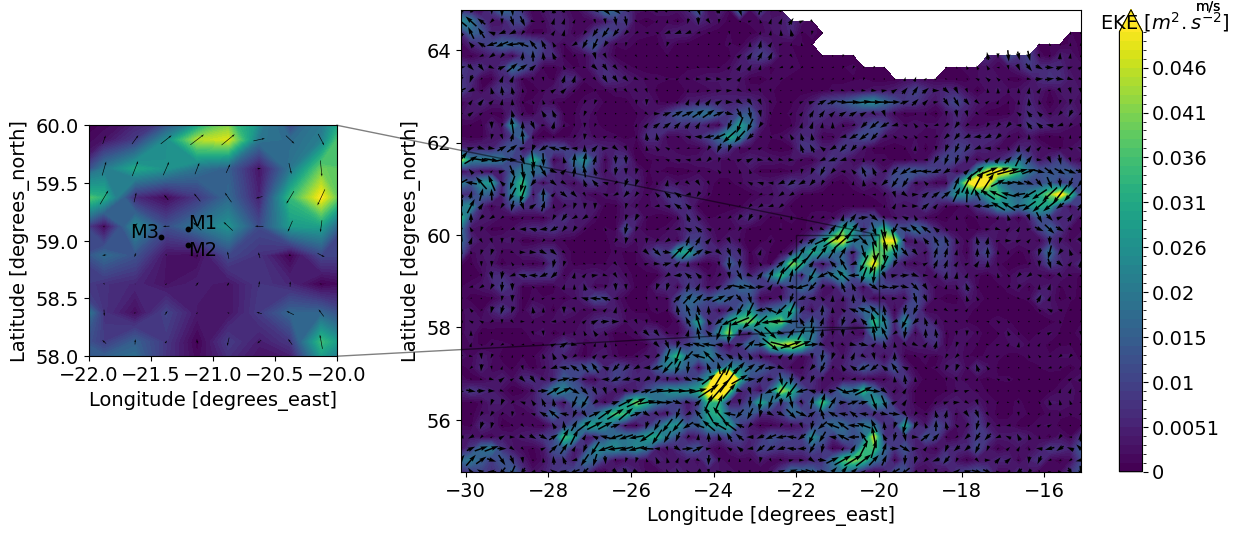

In [28]:
t = '2020-01-14'
fig,ax = plt.subplots(figsize=(10,6))
c1 = alt.eke.sel(time=t,method='nearest').plot.contourf(ax=ax,vmax=0.05,vmin=0,levels=50,cmap='viridis',add_colorbar=False)
alt.sel(time=t,method='nearest').plot.quiver(ax=ax,x='lon',y='lat',u='ugosa',v='vgosa')
#ax.scatter(m1lon,m1lat,s=2);ax.scatter(m2lon,m2lat,s=2);ax.scatter(m3lon,m3lat,s=2)
axins = ax.inset_axes([-0.6, 0.25, 0.4, 0.5])
alt.eke.sel(time=t,method='nearest').plot.contourf(ax=axins,vmax=0.05,vmin=0,levels=50,cmap='viridis',add_colorbar=False)
alt.sel(time=t,method='nearest').plot.quiver(ax=axins,x='lon',y='lat',u='ugos',v='vgos',scale=5)
#alt.plot.quiver(ax=axins,x='lon',y='lat',u='ugos_mean',v='vgos_mean')
ax.set_title('')
    #fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
axins.set_xlim((-22),(-20))
axins.set_ylim((58),(60))
axins.scatter(m1lon,m1lat,s=10,c='k');axins.scatter(m2lon,m2lat,s=10,c='k');axins.scatter(m3lon,m3lat,s=10,c='k')
    #axins.set_ylabel('');axins.set_xlabel('')
axins.text(m1lon,m1lat,'M1',fontsize=14);axins.text(m2lon,m2lat-0.1,'M2',fontsize=14);axins.text(m3lon-0.25,m3lat,'M3',fontsize=14)
axins.set_title('')
ax.indicate_inset_zoom(axins,edgecolor='black')
cb1 = fig.colorbar(c1, format=tkr.FormatStrFormatter('%.2g'))
cb1.set_label(r'EKE [$m^2.s^{-2}$]', labelpad=-40, y=1.05, rotation=0)
plt.show();
fig.tight_layout()

In [62]:
time = alt.sel(time=slice('2019-12-22','2020-02-01')).time.values
for i,t in enumerate(time[:]):
    fig,ax = plt.subplots(figsize=(10,6))
    c1 = alt.eke.sel(time=t,method='nearest').plot.contourf(ax=ax,vmax=0.05,vmin=0,levels=50,cmap='viridis',add_colorbar=False)
    alt.sel(time=t,method='nearest').plot.quiver(ax=ax,x='lon',y='lat',u='ugosa',v='vgosa')
    #ax.scatter(m1lon,m1lat,s=2);ax.scatter(m2lon,m2lat,s=2);ax.scatter(m3lon,m3lat,s=2)
    axins = ax.inset_axes([-0.6, 0.25, 0.4, 0.5])
    alt.eke.sel(time=t,method='nearest').plot.contourf(ax=axins,vmax=0.05,vmin=0,levels=50,cmap='viridis',add_colorbar=False)
    alt.sel(time=t,method='nearest').plot.quiver(ax=axins,x='lon',y='lat',u='ugosa',v='vgosa',scale=2,width=0.01)
    #alt.plot.quiver(ax=axins,x='lon',y='lat',u='ugos_mean',v='vgos_mean')
    ax.set_title('')
        #fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
    axins.set_xlim((-22),(-20))
    axins.set_ylim((58),(60))
    axins.scatter(m1lon,m1lat,s=10,c='r');axins.scatter(m2lon,m2lat,s=10,c='r');axins.scatter(m3lon,m3lat,s=10,c='r')
        #axins.set_ylabel('');axins.set_xlabel('')
    axins.text(m1lon,m1lat,'M1',fontsize=14,c='r');axins.text(m2lon,m2lat-0.1,'M2',fontsize=14,c='r');
    axins.text(m3lon-0.25,m3lat,'M3',c='r',fontsize=14)
    axins.set_title('Time: %s'%str(t))
    ax.indicate_inset_zoom(axins,edgecolor='black')
    cb1 = fig.colorbar(c1, format=tkr.FormatStrFormatter('%.2g'))
    cb1.set_label(r'EKE [$m^2.s^{-2}$]', labelpad=-40, y=1.05, rotation=0)
    #plt.show();
    fig.tight_layout()
    fig.savefig('/Users/zcasparcohen/Documents/fig/t%s'%i)
    fig.clear()
    plt.close(fig)